### <span style="color:brown">Notebook Instructions</span>

- <i>  <span style="color:#FFFF00; background:#00C000"> <b> Please download the notebook available as downloads in the next unit. </b> It will not run in the browser.</i>
- <i> <span style="color:#00C000"> DNN models are very heavy and it is possible that your code will take time to run. Be patient and try again if required. Keep your CPU free of other burdens during the time of run! </i>

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.


#### You will not be able to run this Notebook on the Quantra portal as some of the cells are converted to RawNB format. When running this model on your system, please convert the cells in RawNBConvert format type to Code type, using the dropdown present in the menu bar of the Jupyter Notebook. ####

# Simulation of Trading using Machine Learning Based Model

In this notebook, we will learn how to use machine learning models in simulation, and how to retrain the models whenever the performance drops. The notebook is divided into the following parts

1. Load the libraries and raw data
2. Create a function to generate the features
3. Split the data to train and simulation
4. Create a function to train a model
5. Create a function to save a model
6. Create a function to load a model
7. Create a function to re-train a model
8. Perform the simulation

### Load the libraries and raw data

We first load the necessary libraries which we will be using during the course of this notebook.
Next, we import the daily data of Bank of America from .csv file and save it in a dataframe called data_total

In [1]:
import sys
sys.path.append("..")

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from data_modules.Keras_CV import create_new_model
from tensorflow.keras.models import model_from_json
import json
from tensorflow.keras.callbacks import ModelCheckpoint

# Libraries for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

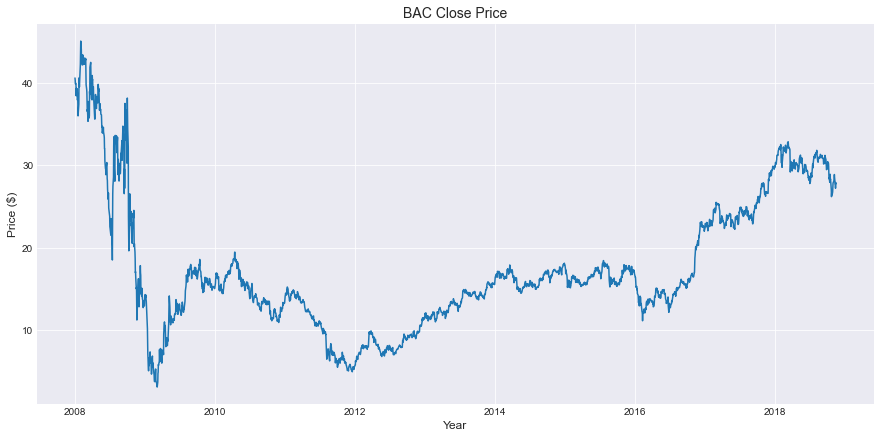

In [2]:
# Load the data from a the file
data_total = pd.read_csv('../data_modules/BAC.csv',
                         index_col=0, parse_dates=True)

# Plot the close price
# Define the plot figure
plt.figure(figsize=(15, 7))

# Plot the data to visualize it
plt.plot(data_total.close)

# Set the title and axis labels
plt.title('BAC Close Price', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)

# Display the plot
plt.show()

### Create a function to generate the features

In the previous sections, we have created features directly using the dataframe, here we will be using a function that will take the dataframe as input and return the features. While performing a simulation we will need to create the features at every data point, so to perform this repetitive task we create a function which will be called whenever we need to create the features.


In [3]:
# This function takes the raw data as its input.
def create_features(data):

    # Returns
    data = data.copy()
    initial_columns = set(data.columns)

    # Future returns
    data['retFut1'] = data.close.pct_change().shift(-1)

    predictor_list = list(initial_columns)

    # Define predictor variables (X) and a target variable (y)
    X = data[predictor_list]
    y = np.where(data.retFut1 > 0, 1, 0)
    y = pd.Series(y)

    return X, y

In [4]:
# Call the function to generate the datasets
X, y = create_features(data_total)

In [5]:
# Visualize the data
X.head()

,volume,open,close,high,low
date,,,,,
2008-01-02 00:00:00+00:00,30764600.0,41.53,40.56,41.55,40.35
2008-01-03 00:00:00+00:00,22589500.0,40.63,40.30,40.81,40.25
2008-01-04 00:00:00+00:00,34921700.0,40.00,39.85,40.29,39.76
2008-01-07 00:00:00+00:00,31884400.0,40.05,39.90,40.24,39.26
2008-01-08 00:00:00+00:00,42143300.0,40.18,38.41,40.21,38.28


#### Please note that the first 20 rows have been dropped as they contain null values 

#### Decide the simulation parameters

We decide the length of the data that will be used to perform the simulation

In [6]:
simulation_length = 252

#### Calculate the minimum data needed to generate one data point

We have used the dropna function in the create_features function earlier. This will result in dropping those first few rows in the dataset that contain null values in the feature data. We have seen earlier that the first 20 rows get dropped when we create the features. So we need to include the past 20 rows of data to generate all features for a single data point. 

In case, if you want to add more features this value would keep changing. To solve this problem, we have added a simple variable called minimum_feature_length that will give us the minimum number of data points needed to make a prediction for one data point.

In [7]:
minimum_feature_length = len(data_total)-len(X)+1
# Here we add one to represent the one data point that would have all the features after dropping the null values

### Decide the past performance parameter

While performing the simulation we need to check the past performance of the model. So, we create a variable called performance_length to assign this value to it. Here we will check the performance of the model over the past 20 data points

In [8]:
performance_length = 20

In [9]:
minimum_feature_length, simulation_length, performance_length

(1, 252, 20)

### Split the data to train and simulation

Now, we will split the initial raw data loaded from the local machine into two datasets:

1. Train --------> data_train   
2. Simulation--> data_sim

In [10]:
# Create the simulation data we need the minimum length of data to create one data point with all features. So we need at least
# minimum_feature_length of data.
# Since we also need to measure the past performance for every data point in the simulation, we need to include
# performance_length of data for a single data point in the simulation.
# Finally, we need to perform the simulation on data points to equal the length to a variable simulation_length.
data_sim = data_total[-(minimum_feature_length +
                        performance_length+simulation_length):].copy()

# Assign the remaining data to train dataset
data_train = data_total[:-(minimum_feature_length +
                           performance_length+simulation_length)].copy()

# Create the features and target datasets for the train data. We will use these to create our initial model,
# which we would be using to begin the simulation with.
X, y = create_features(data_train)

#### You will need to convert the below cell to code format to run it

In [11]:
model = create_new_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                120       
                                                                 
 activation (Activation)     (None, 20)                0         
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                840       
                                                                 
 activation_1 (Activation)   (None, 40)                0         
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 60)                2

### Create a function to train a model

We will be training multiple models when performing the simulation. So we create a function called train_model to handle this repetitive step. This function takes the feature(X) and target(y) datasets as its input and returns a trained model. 


#### You will need to convert the below cell to code format to run it

In [13]:
def train_model(X, y):
    # Instantiate the Machine Learning model
    model = create_new_model(neurons=8, act_1='relu', dropout_ratio=0.02)

    filepath = 'weights-best2.hdf5'
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_loss', save_best_only=True, mode='auto')
    # Fit the data to the model to train it
    model.fit(X, y, epochs=10, batch_size=1, verbose=0, validation_split=0.2,
              callbacks=[checkpoint])
    # Return the model as output
    return model


model = train_model(X, y)

### Create a function to save a model

In a simulation, we will be saving the trained model multiple times. So we create a function called save_model to handle this repetitive step. This function takes the model name and model's saved name as its input and saves the model on the local machine. 

#### You will need to convert the below cell to code format to run it

In [14]:
def save_model(model_name, model_saved_name):
    model_json = model_name.to_json()
    with open("{}.json".format(model_saved_name), "w") as json_file:
        json.dump(model_json, json_file)
    model.save_weights("{}.h5".format(model_saved_name))


model_saved_name = 'challenges_model_save'
save_model(model, model_saved_name)

### Create a function to load a model

We will be loading the trained model at every data point. So we create a function called load_model to handle this repetitive step. This function takes the model's saved name as its input and loads the model from the local machine. 

#### You will need to convert the below cell to code format to run it

In [15]:
def load_model(model_saved_name):
    with open("{}.json".format(model_saved_name), "r") as json_file:
        json_model = json.load(json_file)
        model = model_from_json(json_model)
        model.load_weights("{}.h5".format(model_saved_name))
    return model

### Retrain the model

We need to retrain a model whenever its performance goes bad. When retraining a model, we need to perform the tasks of creating the features, loading the model and saving the final model on the local machine. To do these multiple tasks, we created a simple function called train_new_model. This function takes the raw data and the saved name of the model as input.

#### You will need to convert the below cell to code format to run it

In [16]:
def train_new_model(data, model_saved_name):
    # Create feature from the raw data
    X, y = create_features(data)
    # Train the model on the features generated
    model = train_model(X, y)
    # Save the model on the local machine
    save_model(model, model_saved_name)

### Perform the simulation

We start the simulation by leaving the initial data points needed to avoid the data leakage and then creating the features for the simulation data. For every iteration, we move one data point at a time and then load the past data, perform the feature creation, and model performance analysis.

 ### <font color='red'>The simulation can take days, as the model will be trained multiple times. If you want to reduce the train time you can try increasing the batch size of the model.</font>

In [17]:
# Create a list to save the performance during the simulation
strategy_perf = []
for i in range(simulation_length):
    # Load enough past data points to check the performance and to create features for the these past data points.
    # The features of the last data point in the dataset past_data
    # will be used to make a prediction if the past performance of the model is good.
    past_data = data_sim[i:i+minimum_feature_length+performance_length]
    # Create the features and targets over the past_data
    X, y = create_features(past_data)
    # Load model from the local machine
    model = load_model(model_saved_name)
    # Predict using the loaded model
    predictions = model.predict(X)
    # Convert the probability given by the model to signals
    predictions = np.where(predictions > 0.5, 1, 0)
    # Check of the model's performance over the performance_length
    accuracy = accuracy_score(y.iloc[:-1], predictions[:-1])
    # If the performance is satisfactory then use the prediction on the last data point
    if accuracy > 0.55:
        print("\nStrategy's past performance is good")
        print("\nToday's trading signal is: {}".format(
            "Buy" if predictions[-1] > 0 else "Sell"))
        # Add the prediction of the model to the list strategy_perf, we will use this to check the strategy's performance
        strategy_perf.append(1 if predictions[-1][0] > 0.5 else -1)
    else:
        print("\nRetraining the model")
        print("\nNot trading for today")
        # Since we wont be training at this data point, we will adding 0 to the list strategy_perf
        strategy_perf.append(0)
        # Create a copy of the new train data by rolling forward the train data set by the iteration value
        # As we move forward in the simulation the old data that doesn't over lap with the current simulation data
        # can be added to the train data
        data = data_train[i:-(minimum_feature_length +
                              performance_length+simulation_length)+i].copy()
        # Re-train the model and create a new model using the 'data'
        train_new_model(data, model_saved_name)


Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past per

In [18]:
# Let us check the trading signals generated during the simulation
strategy_perf

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,

### Check the strategy performance on the simulation data

We use the signals stored in the strategy_perf to check the performance of during the entire simulation

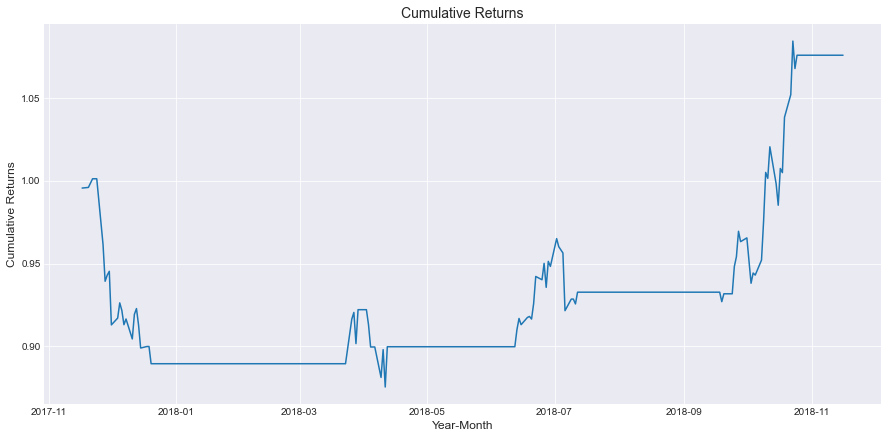

In [19]:
# Multiply the future percentage returns with the signals generated to calculate the strategy's performance
strategy_perf1 = pd.Series(
    np.array(strategy_perf) * data_sim.close.pct_change().shift(-1).iloc[-simulation_length:].values)

data_total['Strategy Returns'] = np.nan
data_total.iloc[-simulation_length:]['Strategy Returns'] = np.nancumprod(strategy_perf1 + 1)

# Plot the cumulative returns
# Define the plot figure
plt.figure(figsize=(15, 7))

# Plot the data to visualize it
plt.plot(data_total[-simulation_length:]['Strategy Returns'])

# Set the title and axis labels
plt.title('Cumulative Returns', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)

# Display the plot
plt.show()

## Practice

You can try it yourself on a new data set and see how the simulation works